<a href="https://colab.research.google.com/github/PSCPU/recommendation-engines/blob/main/Word2vec-product-recommendation-enegine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Import the necessary modules

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
!pip install umap-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=b63749478340a91ebc0de8b0b82e0ec02586cd09a20ad40f0dede916854611d9
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=2f3e898a64f6ed3ee2b01e5a21a8cd03c2a61d1b37c1fdcb6e37261371223970
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


Step 2: Read the dataframe and process it.

In [5]:
import warnings;
warnings.filterwarnings('ignore')


df = pd.read_excel('Online Retail.xlsx')
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [6]:
#Count the number of rows and columns that span the data
df.shape

(541909, 8)

In [8]:
#Identify the attributes with missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
# remove missing values
df.dropna(inplace=True)

In [9]:
# Convert the StockCode to string datatype
df['StockCode']=df['StockCode'].astype(str)

In [10]:
#Check out the number of unique customers in the dataset:
customers=df['CustomerID'].unique().tolist()
len(customers)

4372

In [11]:
#Split the data into training and validation sets, and use the data of 90% of the customers to create word2vec embeddings (training)
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train=[]
for i in range(round(0.9*len(customers))):
               customers_train.append(customers[i])
# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
print(train_df)
validation_df = df[~df['CustomerID'].isin(customers_train)]
print(validation_df) 

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541889    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
541893    581586     20685                DOORMAT RED RETROSPOT        10   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [12]:
#create sequences of purchases made by the customers in the dataset for the training set. 
#This is an important step where the data format actually required for the word2vec model will be generated.

# initiate a list to capture purchase history of the customers
purchases_train = []
# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:03<00:00, 1293.08it/s]


In [13]:
#create sequences of purchases made by the customers in the dataset for the validation set.

# initiate a list to capture purchase history of the customers
purchases_val=[]
#populae the list with product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1870.05it/s]


In [14]:
#Build word2vec Embeddings for Products
# train word2vec model

model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3655266, 3692110)

In [15]:
model.init_sims(replace=True)

In [16]:
print(model)

Word2Vec<vocab=3173, vector_size=100, alpha=0.03>


In [17]:
# extract all vectors
word_vectors = model.wv
X = word_vectors[word_vectors.index_to_key]
X.shape

(3173, 100)

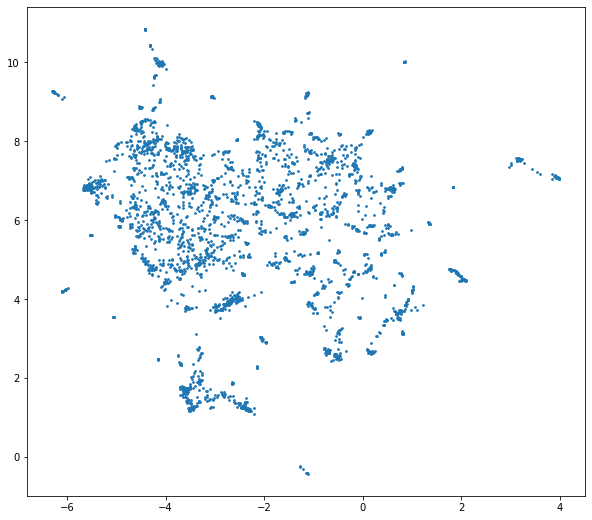

In [18]:
#Visualize word2vec Embeddings after dimensionality reduction using Umap

import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [19]:
#create a product-ID and product-description dictionary to easily map a product’s description to its ID and vice versa.
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [21]:
#Checking the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [22]:
#The following function will take a product’s vector (n) and gives top 6 similar products:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
    for k in new_ms:
        print(k)        

In [23]:
#Trying the function:
similar_products(model.wv['90019A'])

('SILVER M.O.P ORBIT DROP EARRINGS', 0.7851990461349487)
('BLUE MURANO TWIST BRACELET', 0.7773179411888123)
('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7669634819030762)
('PINK BOUDICCA LARGE BRACELET', 0.7619589567184448)
('PINK HEART OF GLASS BRACELET', 0.7510994076728821)
('JADE DROP EARRINGS W FILIGREE', 0.7509053349494934)


In [24]:
#Recommend user products based on the multiple purchases a customer has made in the past
#Take the average of all the vectors of the products the user has bought so far and use this resultant vector to find similar products. 
#The function below that takes in a list of product IDs and gives out a 100-dimensional vector which is a mean of vectors of the products in the input list:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [25]:
#Starting predictions on the validation set now
len(purchases_val[0])

251

In [26]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [29]:
#Get product recommendations based on the entire purchase history of a user
similar_products(aggregate_vectors(purchases_val[0]))

('RED TOADSTOOL LED NIGHT LIGHT', 0.7228374481201172)
('MINI PAINT SET VINTAGE ', 0.7076230049133301)
('SPACEBOY LUNCH BOX ', 0.6950739622116089)
('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.6836857795715332)
('SET/6 RED SPOTTY PAPER CUPS', 0.6821012496948242)
('PLASTERS IN TIN SPACEBOY', 0.676406741142273)


In [30]:
#Get product suggestions based on the last 10 purchases
similar_products(aggregate_vectors(purchases_val[0][-10:]))

('LUNCH BOX WITH CUTLERY RETROSPOT ', 0.7202620506286621)
('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.7004334926605225)
('SPACEBOY LUNCH BOX ', 0.6960306167602539)
('STRAWBERRY LUNCH BOX WITH CUTLERY', 0.6937820911407471)
('POSTAGE', 0.6916598081588745)
('CHILDRENS APRON SPACEBOY DESIGN', 0.6841225028038025)
